## Reproducible Jupyter Notebook

### Did COVID-19 increase or decrease cycling activity in Norfolk, Virginia?

In [10]:
URL = 'https://data.norfolk.gov/api/views/x3iy-p3xt/rows.csv?accessType=DOWNLOAD'

In [11]:
from urllib.request import urlretrieve
urlretrieve(URL,'norfolk-bike.csv')

('norfolk-bike.csv', <http.client.HTTPMessage at 0x285e5f33a58>)

In [17]:
import pandas as pd
data = pd.read_csv('norfolk-bike.csv',index_col='Date and Time',parse_dates=True)

In [25]:
data.sum()

Elizabeth River Trail - Park Ave/NSU Pedestrians                                                      47181
Elizabeth River Trail - Park Ave/NSU Cyclists                                                          2816
Elizabeth River Trail - Weyanoke Footbridge Pedestrian                                                18958
Elizabeth River Trail - Weyanoke Footbridge Cyclist                                                   14656
Elizabeth River Trail - Larchmont Library Pedestrians                                                108718
Elizabeth River Trail - Larchmont Library Cyclist                                                     49853
Elizabeth River Trail - Plum Point Park Pedestrians                                                  662535
Elizabeth River Trail - Plum Point Park Cyclist                                                       91291
Elizabeth River Trail - Lamberts Point Pedestrians                                                    79453
Elizabeth River Trail - Lamb

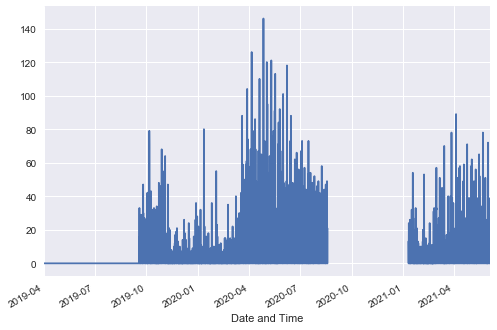

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Plot daily totals
data['Elizabeth River Trail - Plum Point Park Cyclist'].plot()

In [16]:
data.columns

Index(['Elizabeth River Trail - Park Ave/NSU Pedestrians',
       'Elizabeth River Trail - Park Ave/NSU Cyclists',
       'Elizabeth River Trail - Weyanoke Footbridge Pedestrian',
       'Elizabeth River Trail - Weyanoke Footbridge Cyclist',
       'Elizabeth River Trail - Larchmont Library Pedestrians',
       'Elizabeth River Trail - Larchmont Library Cyclist',
       'Elizabeth River Trail - Plum Point Park Pedestrians',
       'Elizabeth River Trail - Plum Point Park Cyclist',
       'Elizabeth River Trail - Lamberts Point Pedestrians',
       'Elizabeth River Trail - Lamberts Point Cyclists',
       'Ocean View Bike Lane Eastbound - Pedestrian',
       'Ocean View Bike Lane Eastbound - Cyclist', 'Date and Time',
       'Day of the Week', 'Month', 'Day of the Month', 'Year'],
      dtype='object')

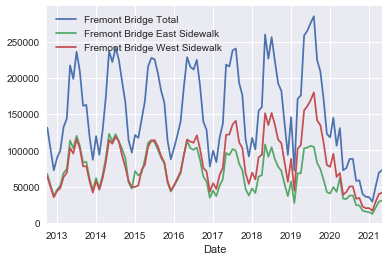

In [6]:
# Plot monthly totals
data.resample('M').sum().plot()

In [7]:
# Let's filter the data to only include the past 2 years
data = data.iloc[-365*24:]

In [8]:
pivoted = data.pivot_table('Fremont Bridge Total', index=data.index.time,columns = data.index.date)
pivoted.iloc[0:5,0:5]

,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05
00:00:00,5.0,2.0,6.0,6.0,1.0
01:00:00,0.0,0.0,2.0,2.0,3.0
02:00:00,1.0,1.0,1.0,3.0,3.0
03:00:00,0.0,3.0,0.0,1.0,2.0
04:00:00,3.0,4.0,3.0,4.0,5.0


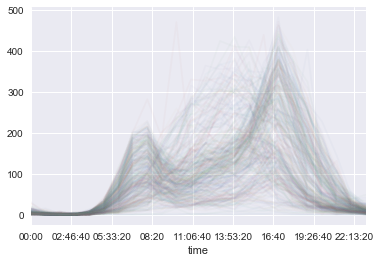

In [9]:
pivoted.plot(legend=False,alpha=0.03)